### Unconditional density estmation
An example of unconditional density estimation with various flow architectures, using the "two moons" distribution.

### Imports

In [1]:
import jax
import jax.numpy as jnp
from jax import random
from flowjax.flows import coupling_flow, masked_autoregressive_flow
from flowjax.bijections.transformers import AffineTransformer, RationalQuadraticSplineTransformer
from flowjax.train_utils import train_flow
from flowjax.distributions import Normal
import matplotlib.pyplot as plt
from sklearn import datasets, preprocessing


### Generate data

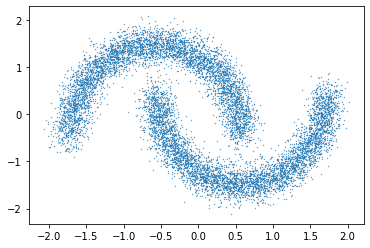

In [2]:
n_samples = 10000
x, _ = datasets.make_moons(n_samples=n_samples, noise=.1)
x = preprocessing.StandardScaler().fit_transform(x)
x = jnp.array(x)
plt.scatter(x[:, 0], x[:, 1], s=0.1)

### Create flows
Here we show how to create flows with two of the most common architectures, coupling flows (see e.g. [RealNVP](https://arxiv.org/abs/1605.08803)), and [masked autoregressive flows](https://arxiv.org/abs/1705.07057). Here we use `AffineTransformer` and [`RationalQuadraticSplineTransformer`](https://arxiv.org/abs/1906.04032) transformers.

In [3]:
key, flow_key = random.split(random.PRNGKey(1)) 
base_dist = Normal(x.shape[1])

flows = {
    "Affine Coupling": coupling_flow(flow_key, base_dist, AffineTransformer()),
    "Spline Coupling": coupling_flow(flow_key, base_dist, RationalQuadraticSplineTransformer(K=8, B=3)),
    "Affine Masked Autoregressive": masked_autoregressive_flow(flow_key, base_dist, AffineTransformer()),
    "Spline Masked Autoregressive": masked_autoregressive_flow(flow_key, base_dist, RationalQuadraticSplineTransformer(K=8, B=3)),
}

100%|██████████| 50/50 [00:23<00:00,  2.13it/s, train=1.93, val=1.87]


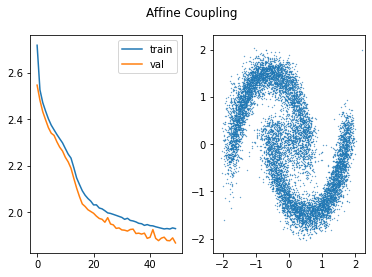

 82%|████████▏ | 41/50 [02:05<00:27,  3.05s/it, train=1.86, val=1.88]

Max patience reached.


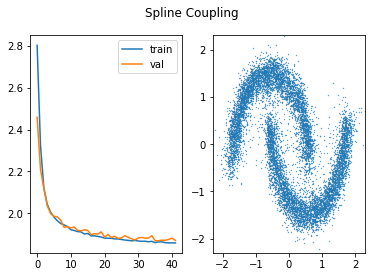

100%|██████████| 50/50 [00:25<00:00,  1.93it/s, train=2.07, val=2.05]


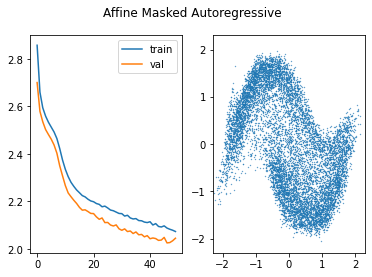

 86%|████████▌ | 43/50 [02:16<00:22,  3.17s/it, train=1.87, val=1.88]

Max patience reached.


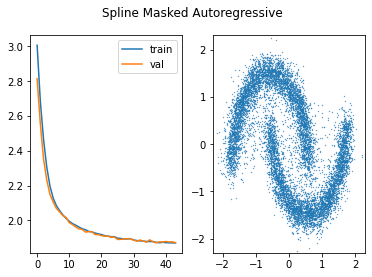

In [4]:

for flow_name, flow in flows.items():
    key, subkey = random.split(key)
    flow, losses = train_flow(subkey, flow, x)

    key, subkey = random.split(key)
    x_samples = flow.sample(key, n=10000)

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(flow_name)

    for k, v in losses.items():
        ax1.plot(v, label=k)
    ax1.legend()

    ax2.scatter(x_samples[:, 0], x_samples[:, 1], s=0.1)
    lims = (-2.3, 2.3)
    ax2.set_xlim(*lims)
    ax2.set_ylim(*lims)
    plt.show()


### Density estimation
We can evaluate the probability of arbitrary points

In [9]:
five_points = jnp.linspace(0, 1, num=10).reshape((5,2))
flow.log_prob(five_points)

DeviceArray([-4.410984 , -2.8378725, -1.1903837, -4.7476697, -8.17219  ],            dtype=float32)

### Accessing the bijection
We can access the bijection and transform specific points if desired.

In [8]:
x = jnp.ones(2)
y = flow.bijection.transform(x)  # Batching not supported for bijections - use jax.vmap if required!
x_reconstructed = flow.bijection.inverse(y)
print("Original ", x)
print("Transformed", y)
print("Inverted", x_reconstructed)

Original  [1. 1.]
Transformed [0.38945606 0.7617262 ]
Inverted [1.0000012 0.9999995]
